<a href="https://colab.research.google.com/github/HegdeSiddesh/cs6910_assignment1/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment 1: Build FeedForward Neural Network Architecture 

The goal of this assignment is twofold: (i) implement and use gradient descent (and its variants) with
backpropagation for a classification task (ii) get familiar with wandb which is a cool tool for running and keeping track of a large number of experiments

### Import required packages

In [1]:
from keras.datasets import fashion_mnist
from sklearn import metrics
from keras.datasets import mnist
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import random
import warnings
warnings.filterwarnings("ignore")
np.random.seed(137) # To ensure that the random number generated are the same for every iteration
!pip install wandb -qq
import wandb

     |████████████████████████████████| 1.7 MB 19.4 MB/s 
     |████████████████████████████████| 181 kB 35.0 MB/s 
     |████████████████████████████████| 144 kB 38.7 MB/s 
     |████████████████████████████████| 63 kB 1.3 MB/s 


### Log in to wandb

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb.init(project="Assignment_1", name="Question_1")

wandb: Currently logged in as: hegdesiddesh (use `wandb login --relogin` to force relogin)


##Question 1

Download the fashion-MNIST dataset and plot 1 sample image for each class.

The class labels are one hot encoded so that they can be utilized by the models created below.

In [2]:
#Load the fashion MNIST data 
(x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()

#Normalize the data
x_train_full = x_train_full/255.0
x_test = x_test/255.0

#Splitting to get 10% data as validation set
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.1, random_state=137)

y_train_unencoded = y_train
#One hot encoding of the class labels
encoder = OneHotEncoder()
y_train = encoder.fit_transform(np.expand_dims(y_train,1)).toarray()
y_val = encoder.fit_transform(np.expand_dims(y_val,1)).toarray()
y_test = encoder.fit_transform(np.expand_dims(y_test,1)).toarray()

4431872/4422102 [==============================] - 0s 0us/step


### Plotting 1 image per class onto console and logging the same to wandb

In [3]:
#Get indices for the unique class labels
unique_indices = np.unique(y_train_unencoded, return_index=True)

# Label reference : https://github.com/zalandoresearch/fashion-mnist
image_label = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}
labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

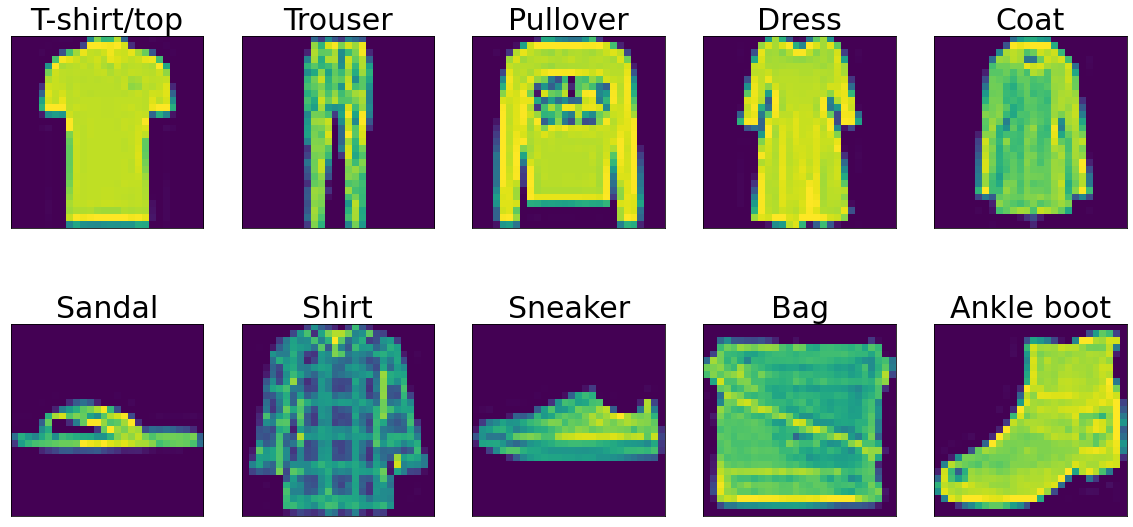

In [ ]:
image_num=0
f, axarr = plt.subplots(2,5, sharex='col', sharey='row', figsize=(20,20))
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)

# Plotting 2*5 subplot of images of different labels
for i in range(0,2):
  for j in range(0,5):
    axarr[i,j].imshow(x_train[unique_indices[1][image_num]])
    axarr[i,j].set_title(image_label[image_num], fontdict = {'fontsize' : 30})
    axarr[i,j].set_xticks([])
    axarr[i,j].set_yticks([])
    caption = image_label[image_num]
    wandb.log({"examples": [wandb.Image(x_train[unique_indices[1][image_num]], caption=caption)]})
    image_num += 1

plt.show()

In [ ]:
wandb.finish()

##Question 2

Implement a feedforward neural network which takes images from the fashion-mnist data as input and outputs a probability distribution over the 10 classes.

Your code should be flexible so that it is easy to change the number of hidden layers and the number of neurons in each hidden layer.

**Functionalities included:**
1. Forward propogation with sigmoid, relu, tanh activation for hidden layers and softmax activation for output layer
2. Returns the class predictions for each datapoint x after a single forward pass
3. Flexible hidden layer count and sizes as passed during fit function call

**(Assuming that the Question asks only for forward-propogation in the FeedForward Neural Network. In case forward + backward propogation was expected, kindly check the cells for Question 3 which have the complete implemenattion of the FeedForward Neural Network)**





In [4]:
class FeedForwardNeuralNetwork():
  """
  Class to implement the feed forward neural network's forward propogation functonality. Hidden layer sizes are flexible and 4 different activations are supported

  Attributes:
      hidden_layer_sizes: List with the hidden layer sizes (list size indicates the number of hidden layers for the network)
  """
  def __init__(self, hidden_layer_sizes):
    self.hidden_layer_sizes = hidden_layer_sizes
    self.input_layer_size=0
    self.output_layer_size=1
    self.weights = {}
    self.biases = {}
    self.A = {}
    self.H = {}

    #Layer sizes array will be initialzed after input and output layer size is obtained
    self.layer_sizes = []

  def initialize_weights(self):
    """
    Function to initialize the weights between the layers of the network. Weights are initialized randomly.
    """
    self.layer_sizes = [self.input_layer_size] + self.hidden_layer_sizes + [self.output_layer_size]
    weight_counts = len(self.hidden_layer_sizes)+1
    np.random.seed(137)
    np.random.RandomState(137)
    for i in range(weight_counts):
      # Setting up the weights per layer. Initialized randomly as matrix of size of previous layer * next layer 
      self.weights[i+1] = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1])
      # Setting up the biases per layer. Initialized to 0 as matrix of size of 1 * next layer 
      self.biases[i+1] = np.zeros((1, self.layer_sizes[i+1]))
  
  def compute_activation(self, name, X):
    """
    Function to compute activation based on the name of activation function passed. This function in turn calls the required activation.
    """
    if name=="sigmoid":
      return self.sigmoid(X)
    if name=="relu":
      return self.tanh(X)
    if name=="tanh":
      return self.relu(X)

  def softmax(self, X):
    #Utility to compute softmax function
    exponentials = np.exp(X)
    return exponentials / np.sum(exponentials)

  def sigmoid(self,X):
    #Utility to compute sigmoid function
    return 1.0/(1.0+np.exp(-X))

  def cross_entropy(self,Y_true,Y_pred):
    #Utility to compute cross entropy loss
    loss=np.multiply(Y_pred,Y_true)
    loss=loss[loss!=0]
    loss=-np.log(loss)
    loss=np.mean(loss)
    return loss

  def tanh(self,X):
    # Utility to compute tanh function
    return np.tanh(X)

  def relu(self,X):
    # Utility to compute relu function
    return X * (X > 0)

  def forward_propogation(self, activation, X):
    """
    Function to perform forward propogation on the data X.
    """
    self.A = {}
    self.H = {}
    #Initialize the output from input layer as H[0] into a single row(row vector)
    self.H[0] = X.reshape(1,-1)

    #Compute a(x) = W_x*h(x-1) + b and h(a(x)) = activation(a(x)) for hidden layer
    for i in range(len(self.hidden_layer_sizes)):
      self.A[i+1] = np.matmul(self.H[i], self.weights[i+1]) + self.biases[i+1]
      self.H[i+1] = self.compute_activation(activation, self.A[i+1])

    #Compute a(x) and h(a(x)) = softmax(a(x)) for output layer
    self.A[len(self.hidden_layer_sizes)+1] = np.matmul(self.H[len(self.hidden_layer_sizes)], self.weights[len(self.hidden_layer_sizes)+1]) + self.biases[len(self.hidden_layer_sizes)+1]
    self.H[len(self.hidden_layer_sizes)+1] = self.softmax(self.A[len(self.hidden_layer_sizes)+1]) 
    return


  def fit(self, activation, X, Y):
    """
    Function to fit the data (X,Y) on the model. This performs a single forward pass and returns the probabilities computed at the output layer
    """
    self.input_layer_size = X.shape[1]*X.shape[1] # Number of features in data(features)
    self.output_layer_size = Y.shape[1] # Number of columns in output (label count)
    self.initialize_weights()
    y_preds = []
    for x, y in zip(X, Y):
      #Forward Propogation
      self.forward_propogation(activation, x)

      y_preds.append(self.H[len(self.hidden_layer_sizes)+1][0])
    return y_preds
 


### Create an object for the FeedForwardNeuralNetwork class and get class probabilities for the data passed

In [5]:
#Sample implementation using 3 hidden layers of sizes 100, 256 and 512 respectively

model = FeedForwardNeuralNetwork([100,256, 512])
activation_name = "relu"
class_predictions = model.fit(activation_name, x_train, y_train)

In [6]:
# Class probabilities for 0th indexed image

np.set_printoptions(suppress=True)
class_predictions[0]

array([0.99455091, 0.        , 0.        , 0.00000199, 0.00001175,
       0.        , 0.00042277, 0.00500862, 0.00000396, 0.00000001])

##Question 3

Implement the backpropagation algorithm with support for the following optimization functions:
* SGD
* Momentum based gradient descent
* Nesterov accelerated gradient descent
* Rmsprop
* Adam
* Nadam

In addition to this, the below section includes the following:
1. Implementation classes for the Sigmoid, Relu, Tanh, Softmax activation functions
2. Implementation classes for Cross entropy loss and Squared error loss functions
3. Provision to choose between Random, Xavier-Normal and Xavier-Uniform weight initialization
4. FeedForwardNeuralNetwork class modified to allow optimizer, hidden layer activation, output layer activation, loss function, hidden layer details, epochs, batch size, weight initialization, ... to be sent as a parameter
5. Accuracy and Loss printed for each epoch for Training and validation data

**Adding a new Optimizer/Activation/Loss function is as simple as creating a class for the same with a a structure following that as other classes and passing it as a parameter to the object of the FeedForwardNeuralNetwork class**

### Creating utility functions

In [7]:
#An independent function which computed accuracy given the true and predicted class labels
def accuracy(y_true, y_pred):
  """
  Utility function to compute the accuracy given true and predicted class labels
  """
  acc = np.sum(np.equal(y_true,y_pred))/y_true.shape[0]
  return acc

### Creating the FeedForwardNeuralNetwork class

In [8]:
class FeedForwardNeuralNetwork():
  """
  Class to implement the feed forward neural network's forward propogation functonality.

  Attributes:
      hidden_layer_sizes:List with the hidden layer sizes (list size indicates the number of hidden layers for the network)
      optimizer:Object for the optimizer to be used.
      loss_function:Object for the loss function to be used.
      activation_function:Object for the activation function to be used at the hidden layers.
      output_activation:Object for the activation function to be used at the output layer.
      epochs:Number of epochs (default 1000)
      batch_size:Batch size (default 1024)
      initialization:Weight initialization (default "Random")
      log:Log onto wand (default 0)
      console_log:Log onto console (default 1)
      train_losses_list:List for saving training loss per epoch (default None)
      train_accuracy_list:List for saving training accuracy per epoch (default None)
      val_losses_list:List for saving validation loss per epoch (default None)
      val_accuracy_listList for saving validation accuracy per epoch (default None)
  """
  def __init__(self, hidden_layer_sizes, optimizer, loss_function, activation_function, output_activation, epochs = 1000, batch_size = 1024, initialization = "Random", log=0, console_log = 1, train_losses_list = None, train_accuracy_list = None, val_losses_list = None, val_accuracy_list = None):
    self.hidden_layer_sizes = hidden_layer_sizes
    self.optimizer = optimizer
    self.loss_function = loss_function
    self.activation_function = activation_function
    self.output_activation = output_activation
    self.input_layer_size=0
    self.output_layer_size=1
    self.epochs = epochs
    self.batch_size = batch_size
    self.initialization = initialization
    self.weights = {}
    self.biases = {}
    self.A = {}
    self.H = {}
    self.dw = {}
    self.db = {}
    self.dA = {}
    self.dH = {}
    #Layer sizes array will be initialzed after input and output layer size is obtained
    self.layer_sizes = []
    self.log = log
    self.console_log = console_log
    self.val_losses_list = val_losses_list
    self.val_accuracy_list = val_accuracy_list
    self.train_losses_list = train_losses_list
    self.train_accuracy_list = train_accuracy_list


  def initialize_weights(self):
    """
    Function to initialize the weights between the layers of the network. Weights are initialized randomly.
    """
    self.layer_sizes = [self.input_layer_size] + self.hidden_layer_sizes + [self.output_layer_size]
    weight_counts = len(self.hidden_layer_sizes)+1
    np.random.seed(137)
    np.random.RandomState(137)
    self.optimizer.initialize(self.layer_sizes)
    for i in range(weight_counts):

      if self.initialization == "Random":
        # Setting up the weights per layer. Initialized randomly as matrix of size of previous layer * next layer 
        self.weights[i+1] = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1])

      if self.initialization == "Xavier-Normal":
        limit = np.sqrt(2 / float(self.layer_sizes[i] + self.layer_sizes[i+1]))
        self.weights[i+1] = np.random.normal(0.0, limit, size=(self.layer_sizes[i], self.layer_sizes[i+1]))

      if self.initialization == "Xavier-Uniform":
        limit = np.sqrt(6 / float(self.layer_sizes[i] + self.layer_sizes[i+1]))
        self.weights[i+1] = np.random.uniform(low=-limit, high=limit, size=(self.layer_sizes[i], self.layer_sizes[i+1]))

      # Setting up the biases per layer. Initialized to 0 as matrix of size of 1 * next layer 
      # Creates a row of biases corresponding to each weight of the layer
      self.biases[i+1] = np.zeros((1, self.layer_sizes[i+1]))


  def forward_propogation(self, X):
    """
    Function to perform forward propogation on the data X.
    """
    self.A = {}
    self.H = {}
    #Initialize the output from input layer as H[0] into a single row(row vector)
    self.H[0] = X.reshape(1,-1)

    #Compute a(x) = W_x*h(x-1) and h(a(x)) = activation(a(x)) for hidden layer
    for i in range(len(self.hidden_layer_sizes)):
      self.A[i+1] = np.matmul(self.H[i], self.weights[i+1]) + self.biases[i+1]
      self.H[i+1] = self.activation_function.compute_activation(self.A[i+1])

    #Compute a(x) and h(a(x)) = softmax(a(x)) for output layer
    self.A[len(self.hidden_layer_sizes)+1] = np.matmul(self.H[len(self.hidden_layer_sizes)], self.weights[len(self.hidden_layer_sizes)+1]) + self.biases[len(self.hidden_layer_sizes)+1]
    self.H[len(self.hidden_layer_sizes)+1] = self.output_activation.compute_activation(self.A[len(self.hidden_layer_sizes)+1]) 
    return

  def backward_propogation(self, X, Y,  dw_i, db_i):
    """
    Function to perform backward propogation on the network. 
    """
    #Compute the gradient of loss wrt the activation of output layer
    self.dA[len(self.hidden_layer_sizes)+1] = self.loss_function.last_output_derivative(self.H[len(self.hidden_layer_sizes)+1], Y, self.output_activation.compute_derivative(self.A[len(self.hidden_layer_sizes)+1]))

    #Compute the partial derivatives for the weights and biases of the layers
    for i in range(len(self.hidden_layer_sizes), -1, -1):
      #eg:(assuming 2 hidden layers) dL/dW3 = dA3/dW3 * dL/dA3 = d(W3*H2 + B3)/dW3 * dL/dA3 = H2 * dL/dA3
      dw_i[i+1] = np.matmul(self.H[i].T, self.dA[i+1])
      #eg:(assuming 2 hidden layers) dL/dB3 = dA3/dB3 * dL/dA3 = d(W3*H2 + B3)/dB3 * dL/dA3 = 1 * dL/dA3
      db_i[i+1] = self.dA[i+1]
      if i!=0:
        #eg:(assuming 2 hidden layers) dL/dH2 = dA3/dH2 * dL/dA3 = d(W3*H2 + B3)/dH2 * dL/dA3 = W3 * dL/dA3
        self.dH[i] = np.matmul(self.dA[i+1],self.weights[i+1].T)
        #eg:(assuming 2 hidden layers) dL/dA2 = dH2/dA2 * dL/dH2 = d(sigmoid(A2))/dA2 * dL/dH2 = sigmoid(A2) * (1-sigmoid(A2)) * dL/dH2 (for sigmoid activation)
        ## THIS IS HADAMARD PRODUCT IE NOT DOT PRODUCT
        self.dA[i] = np.multiply(self.activation_function.compute_derivative(self.A[i]), self.dH[i])    
    return dw_i, db_i


  def fit(self, X, Y, X_val, Y_val):
    """
    Function to fit the data (X,Y) on the model. This performs forward + backward pass for epoch number of times. Gradient is updated after each batch is processed.
    """    
    self.input_layer_size = X.shape[1]*X.shape[1] # Number of features in data(features)
    self.output_layer_size = Y.shape[1] # Number of columns in output (label count)
    self.initialize_weights()
    for e in range(self.epochs):
      y_preds = []

      count = -1
      for i in range(len(self.hidden_layer_sizes)+1):
        self.dw[i+1] = np.zeros((self.layer_sizes[i], self.layer_sizes[i+1]))
        self.db[i+1] = np.zeros((1, self.layer_sizes[i+1]))

      for x, y in zip(X, Y):
        dw_i = {}
        db_i = {}
        count += 1

        if count==self.batch_size:
          #Done wih current batch
          count = 0
          if self.optimizer.optimizer_name()=="nag":
            w_lookahead = {}
            b_lookahead = {}
            for i in range(len(self.hidden_layer_sizes)+1):
              w_lookahead[i+1] = self.weights[i+1] - self.optimizer.gamma*self.optimizer.update_history_w[i+1]
              b_lookahead[i+1] = self.biases[i+1] - self.optimizer.gamma*self.optimizer.update_history_b[i+1]
            
            weights_old = self.weights
            biases_old = self.biases
            self.weights = w_lookahead
            self.biases = b_lookahead
            self.forward_propogation(x)
            dw_lookahead, db_lookahead = self.backward_propogation(x,y, dw_i, db_i) 
            self.weights, self.biases = self.optimizer.update_parameters(weights_old, biases_old, dw_lookahead, db_lookahead, self.hidden_layer_sizes)

          else: 
            self.weights, self.biases = self.optimizer.update_parameters(self.weights, self.biases, self.dw, self.db, self.hidden_layer_sizes)
          for i in range(len(self.hidden_layer_sizes)+1):
            self.dw[i+1] = np.zeros((self.layer_sizes[i], self.layer_sizes[i+1]))
            self.db[i+1] = np.zeros((1, self.layer_sizes[i+1]))


        #Forward Propogation
        self.forward_propogation(x)

        #Predictions
        y_preds.append(self.H[len(self.hidden_layer_sizes)+1])
        
        #Backward Propogation using Loss funtion
        self.backward_propogation(x,y, dw_i, db_i) 

        for i in range(len(self.hidden_layer_sizes)+1):
          self.dw[i+1] += dw_i[i+1]
          self.db[i+1] += db_i[i+1]

      #Update weights based on loss(GD hence once every epoch update)
      if self.optimizer.optimizer_name()=="nag":
        w_lookahead = {}
        b_lookahead = {}
        for i in range(len(self.hidden_layer_sizes)+1):
          w_lookahead[i+1] = self.weights[i+1] - self.optimizer.gamma*self.optimizer.update_history_w[i+1]
          b_lookahead[i+1] = self.biases[i+1] - self.optimizer.gamma*self.optimizer.update_history_b[i+1]
        
        weights_old = self.weights
        biases_old = self.biases
        self.weights = w_lookahead
        self.biases = b_lookahead
        self.forward_propogation(x)
        dw_lookahead, db_lookahead = self.backward_propogation(x,y, dw_i, db_i) 
        self.weights, self.biases = self.optimizer.update_parameters(weights_old, biases_old, dw_lookahead, db_lookahead, self.hidden_layer_sizes)

      else:  
        self.weights, self.biases = self.optimizer.update_parameters(self.weights, self.biases, self.dw, self.db, self.hidden_layer_sizes)
      y_preds = np.array(y_preds).squeeze()
      y_preds_validation = self.predict(X_val)
      training_loss = self.loss_function.compute_loss(Y, y_preds, self.batch_size)
      validation_loss = self.loss_function.compute_loss(Y_val, y_preds_validation, self.batch_size)
      training_accuracy = accuracy(np.argmax(Y,1), np.argmax(y_preds,1))
      validation_accuracy = accuracy(np.argmax(Y_val,1), np.argmax(y_preds_validation,1))
      if self.log==1:
        #Log metrics to wandb
        wandb.log({"Training_accuracy": training_accuracy, "Validation_accuracy": validation_accuracy, "Training_loss": training_loss, "Validation_loss": validation_loss, 'Epoch': e+1})
      if self.console_log == 1:
        #Log results to console
        print("Epoch: ",e+1," Training Loss: ",training_loss, " Validation Loss:",validation_loss ," Training Accuracy: ",training_accuracy, " Validation Accuracy:", validation_accuracy)
      if self.val_accuracy_list != None:
        self.val_accuracy_list.append(validation_accuracy)
      if self.val_losses_list != None:
        self.val_losses_list.append(validation_loss)
      if self.train_accuracy_list != None:
        self.train_accuracy_list.append(training_accuracy)
      if self.train_losses_list != None:
        self.train_losses_list.append(training_loss)
    
    return training_loss, validation_loss, training_accuracy, validation_accuracy

  def predict(self, X):
    """
    Given a list of datapoints X, this function returns the predictions for the data based on the model trained.
    """
    #Find the predictions based on the fitted model
    y_pred = []
    for x in X:
      values = self.forward_propogation(x)
      predictions = self.H[len(self.hidden_layer_sizes)+1]
      y_pred.append(predictions)

    y_pred = np.array(y_pred).squeeze()
    return y_pred
      


### Creating classes for Optimizers

In [10]:
class GD():
  """
  Class to implement Stocastic Gradient Descent optimizer.
  Argumenets:
    learning_rate: Learning rate for the optimizer
    weight_decay: Weight decay for the optimizer
  """
  def __init__(self, learning_rate = 0.001, weight_decay = 0.0):
    self.learning_rate = learning_rate
    self.weight_decay = weight_decay

  def set_learning_rate(self, learning_rate):
    self.learning_rate = learning_rate

  def set_weight_decay(self, weight_decay):
    self.weight_decay = weight_decay

  def set_initial_parameters(self, parameters):
    self.learning_rate = parameters["learning_rate"]
    self.weight_decay = parameters["weight_decay"]

  def initialize(self, all_layers):
    return

  def optimizer_name(self):
    return "gd"

  def update_parameters(self, weights, biases, dw, db, layers):
    """
    Function to perform the weight update step based on optimizer algorithm
    """
    for i in range(len(layers)+1):
        dw[i+1] = dw[i+1] + self.weight_decay*weights[i+1]

        # w_t = w_{t-1} - eta*(dL/dw)
        weights[i+1] = weights[i+1] - self.learning_rate * dw[i+1]
        # b_t = b_{t-1} - eta*(dL/db)
        biases[i+1] = biases[i+1] - self.learning_rate * db[i+1]
    return weights, biases


class MomentumGD():
  """
  Class to implement Momentum Gradient Descent optimizer.
  Arguments:
    learning_rate: Learning rate for the optimizer
    weight_decay: Weight decay for the optimizer
    gamma : Gamma value for the optimizer
  """
  def __init__(self, learning_rate = 0.001, gamma = 0.001, weight_decay = 0.0):
    self.learning_rate = learning_rate
    self.gamma = gamma
    self.initialized = False
    self.weight_decay = weight_decay
    self.update_history_w = {}
    self.update_history_b = {}
  
  def optimizer_name(self):
    return "momentum"

  def set_weight_decay(self, weight_decay):
    self.weight_decay = weight_decay
  
  def initialize(self, all_layers):
    self.update_history_w.clear()
    self.update_history_b.clear()
    for i in range(len(all_layers)-1):
      self.update_history_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.update_history_b[i+1] = np.zeros((1, all_layers[i+1]))
  
  def set_learning_rate(self, learning_rate):
    self.learning_rate = learning_rate

  def set_initial_parameters(self, parameters):
    self.learning_rate = parameters["learning_rate"]
    self.gamma = parameters["gamma"]
    self.weight_decay = parameters["weight_decay"]

  def update_parameters(self, weights, biases, dw, db, layers):
    """
    Function to perform the weight update step based on optimizer algorithm
    """

    for i in range(len(layers)+1):
        dw[i+1] = dw[i+1] + self.weight_decay*weights[i+1]

        self.update_history_w[i+1] =self.gamma*self.update_history_w[i+1] + self.learning_rate*dw[i+1]
        weights[i+1] = weights[i+1] - self.update_history_w[i+1]

        self.update_history_b[i+1] =self.gamma*self.update_history_b[i+1] + self.learning_rate*db[i+1]
        biases[i+1] = biases[i+1] - self.update_history_b[i+1]
        
    return weights, biases


class NAG():
  """
  Class to implement Nesterov accelerated Gradient Descent optimizer.
  Arguments:
    learning_rate: Learning rate for the optimizer
    gamma: Gamma value for the optimizer
  """
  def __init__(self, learning_rate = 0.001, gamma = 0.9):
    self.learning_rate = learning_rate
    self.gamma = gamma
    self.initialized = False
    self.update_history_w = {}
    self.update_history_b = {}
    self.w_look_ahead={}
    self.b_look_ahead={}
    self.dw_look_ahead={}
    self.db_look_ahead={}

  
  def optimizer_name(self):
    return "nag"
  
  def initialize(self, all_layers):
    self.update_history_w.clear()
    self.update_history_b.clear()
    self.dw_look_ahead.clear()
    self.db_look_ahead.clear()
    self.w_look_ahead.clear()
    self.b_look_ahead.clear()

    for i in range(len(all_layers)-1):
      self.update_history_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.update_history_b[i+1] = np.zeros((1, all_layers[i+1]))
      self.dw_look_ahead[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.db_look_ahead[i+1] = np.zeros((1, all_layers[i+1]))
      self.w_look_ahead[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.b_look_ahead[i+1] = np.zeros((1, all_layers[i+1]))

  def set_learning_rate(self, learning_rate):
    self.learning_rate = learning_rate

  def set_initial_parameters(self, parameters):
    self.learning_rate = parameters["learning_rate"]
    self.gamma = parameters["gamma"]


  def update_parameters(self, weights, biases, dw, db, layers):
    """
    Function to perform the weight update step based on optimizer algorithm
    """
    for i in range(len(layers)+1):
        self.update_history_w[i+1] = self.gamma*self.update_history_w[i+1] + self.learning_rate*dw[i+1]
        self.update_history_b[i+1] = self.gamma*self.update_history_b[i+1] + self.learning_rate*db[i+1]

        weights[i+1] = weights[i+1] - self.update_history_w[i+1]
        biases[i+1] = biases[i+1] - self.update_history_b[i+1]
        
    return weights, biases


class RMSProp():
  """
  Class to implement RMSProp optimizer.
  Arguments:
    learning_rate: Learning rate for the optimizer
    weight_decay: Weight decay for the optimizer
    gamma : Gamma value for the optimizer
    epsilon : Epsilon value
  """
  def __init__(self, learning_rate = 0.001, gamma = 0.001, epsilon = 1e-8, weight_decay = 0.0):
    self.learning_rate = learning_rate
    self.gamma = gamma
    self.epsilon = epsilon
    self.v_w = {}
    self.v_b = {}
    self.initialized = False
    self.weight_decay = weight_decay

  def initialize(self, all_layers):
    self.v_w.clear()
    self.v_b.clear()
    for i in range(len(all_layers)-1):
      self.v_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.v_b[i+1] = np.zeros((1, all_layers[i+1]))
  
  def optimizer_name(self):
    return "rmsprop"
  
  def set_learning_rate(self, learning_rate):
    self.learning_rate = learning_rate

  def set_weight_decay(self, weight_decay):
    self.weight_decay = weight_decay

  def set_initial_parameters(self, parameters):
    self.learning_rate = parameters["learning_rate"]
    self.gamma = parameters["gamma"]
    self.epsilon = parameters["epsilon"]
    self.weight_decay = parameters["weight_decay"]


  def update_parameters(self, weights, biases, dw, db, layers):
    """
    Function to perform the weight update step based on optimizer algorithm
    """
    for i in range(len(layers)+1):
        dw[i+1] = dw[i+1] + self.weight_decay*weights[i+1]
        self.v_w[i+1] =self.gamma*self.v_w[i+1] + (1-self.gamma)* ((dw[i+1])**2)
        self.v_b[i+1] =self.gamma*self.v_b[i+1] + (1-self.gamma)* ((db[i+1])**2)

        weights[i+1] = weights[i+1] - ((self.learning_rate)/np.sqrt(self.v_w[i+1] + self.epsilon))*dw[i+1]
        biases[i+1] = biases[i+1] - ((self.learning_rate)/np.sqrt(self.v_b[i+1] + self.epsilon))*db[i+1]
        
    return weights, biases


class Adam():
  """
  Class to implement Adam optimizer.
  Arguments:
    learning_rate: Learning rate for the optimizer
    weight_decay: Weight decay for the optimizer
    beta1 : Beta 1 value for the optimizer
    beta2 : Beta 2 value for the optimizer
    epsilon : Epsilon value
  """
  def __init__(self, learning_rate = 0.001,beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8, weight_decay = 0.0):
    self.learning_rate = learning_rate
    self.beta1 = beta1
    self.beta2 = beta2
    self.epsilon = epsilon
    self.initialized = False
    self.v_w = {}
    self.v_b = {}
    self.m_w = {}
    self.m_b = {}
    self.iterations = 1
    self.weight_decay = weight_decay

  def initialize(self, all_layers):
    self.v_w.clear()
    self.v_b.clear()
    self.m_w.clear()
    self.m_b.clear()
    for i in range(len(all_layers)-1):
      self.v_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.v_b[i+1] = np.zeros((1, all_layers[i+1]))
      self.m_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.m_b[i+1] = np.zeros((1, all_layers[i+1]))

  def set_learning_rate(self, learning_rate):
    self.learning_rate = learning_rate
  
  def set_weight_decay(self, weight_decay):
    self.weight_decay = weight_decay
  
  def optimizer_name(self):
    return "adam"

  def set_initial_parameters(self, parameters):
    self.learning_rate = parameters["learning_rate"]
    self.beta1 = parameters["beta1"]
    self.beta2 = parameters["beta2"]
    self.epsilon = parameters["epsilon"]
    self.weight_decay = parameters["weight_decay"]


  def update_parameters(self, weights, biases, dw, db, layers):
    """
    Function to perform the weight update step based on optimizer algorithm
    """
    for i in range(len(layers)+1):

        dw[i+1] = dw[i+1] + self.weight_decay*weights[i+1]

        self.m_w[i+1] = self.beta1*self.m_w[i+1] + (1-self.beta1)* (dw[i+1])
        self.m_b[i+1] = self.beta1*self.m_b[i+1] + (1-self.beta1)* (db[i+1])
        self.v_w[i+1] = self.beta2*self.v_w[i+1] + (1-self.beta2)* ((dw[i+1])**2)
        self.v_b[i+1] = self.beta2*self.v_b[i+1] + (1-self.beta2)* ((db[i+1])**2)

        m_w_hat = self.m_w[i+1]/(1-(self.beta1**self.iterations))
        m_b_hat = self.m_b[i+1]/(1-(self.beta1**self.iterations))			  
        v_w_hat = self.v_w[i+1]/(1-(self.beta2**self.iterations))
        v_b_hat = self.v_b[i+1]/(1-(self.beta2**self.iterations))

        weights[i+1] = weights[i+1] - ((self.learning_rate)/(np.sqrt(v_w_hat) + self.epsilon))*(m_w_hat)
        biases[i+1] = biases[i+1] - ((self.learning_rate)/(np.sqrt(v_b_hat) + self.epsilon))*(m_b_hat)

    self.iterations += 1
        
    return weights, biases


class Nadam():
  #Reference : http://cs229.stanford.edu/proj2015/054_report.pdf
  #Formula reference: https://towardsdatascience.com/10-gradient-descent-optimisation-algorithms-86989510b5e9
  """
  Class to implement NAdam optimizer.
  Arguments:
    learning_rate: Learning rate for the optimizer
    weight_decay: Weight decay for the optimizer
    beta1 : Beta 1 value for the optimizer
    beta2 : Beta 2 value for the optimizer
    epsilon : Epsilon value
  """
  def __init__(self, learning_rate = 0.001, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8, weight_decay = 0.0):
    self.learning_rate = learning_rate
    self.beta1 = beta1
    self.beta2 = beta2
    self.epsilon = epsilon
    self.initialized = False
    self.v_w = {}
    self.v_b = {}
    self.m_w = {}
    self.m_b = {}
    self.iterations = 1
    self.weight_decay = weight_decay

  def initialize(self, all_layers):
    self.v_w.clear()
    self.v_b.clear()
    self.m_w.clear()
    self.m_b.clear()
    for i in range(len(all_layers)-1):
      self.v_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.v_b[i+1] = np.zeros((1, all_layers[i+1]))
      self.m_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.m_b[i+1] = np.zeros((1, all_layers[i+1]))

  def set_learning_rate(self, learning_rate):
    self.learning_rate = learning_rate

  def set_weight_decay(self, weight_decay):
    self.weight_decay = weight_decay
  
  def optimizer_name(self):
    return "nadam"

  def set_initial_parameters(self, parameters):
    self.learning_rate = parameters["learning_rate"]
    self.beta1 = parameters["beta1"]
    self.beta2 = parameters["beta2"]
    self.epsilon = parameters["epsilon"]
    self.weight_decay = parameters["weight_decay"]


  def update_parameters(self, weights, biases, dw, db, layers):
    """
    Function to perform the weight update step based on optimizer algorithm
    """
    for i in range(len(layers)+1):

        dw[i+1] = dw[i+1] + self.weight_decay*weights[i+1]

        self.m_w[i+1] = self.beta1*self.m_w[i+1] + (1-self.beta1)* (dw[i+1])
        self.m_b[i+1] = self.beta1*self.m_b[i+1] + (1-self.beta1)* (db[i+1])

        self.v_w[i+1] = self.beta2*self.v_w[i+1] + (1-self.beta2)* ((dw[i+1])**2)
        self.v_b[i+1] = self.beta2*self.v_b[i+1] + (1-self.beta2)* ((db[i+1])**2)

        m_w_hat = self.m_w[i+1]/(1-(self.beta1**self.iterations))
        m_b_hat = self.m_b[i+1]/(1-(self.beta1**self.iterations))
			  
        v_w_hat = self.v_w[i+1]/(1-(self.beta2**self.iterations))
        v_b_hat = self.v_b[i+1]/(1-(self.beta2**self.iterations))

        weights[i+1] = weights[i+1] - ((self.learning_rate)/(np.sqrt(v_w_hat) + self.epsilon))*(self.beta1 * m_w_hat + ((1-self.beta1)/(1-(self.beta1**self.iterations))*dw[i+1]))
        biases[i+1] = biases[i+1] - ((self.learning_rate)/(np.sqrt(v_b_hat) + self.epsilon))*(self.beta1 * m_b_hat + ((1-self.beta1)/(1-(self.beta1**self.iterations))*db[i+1]))

    self.iterations += 1
        
    return weights, biases


### Creating classes for Activation functions

In [11]:
class Sigmoid():
  """
  Class to implement Sigmoid activation function.
  """
  def compute_activation(self, X):
    return 1.0/(1.0+np.exp(-X))

  def compute_derivative(self, X):
    val = self.compute_activation(X)
    return val*(1-val)

class Softmax():
  """
  Class to implement Softmax activation function.
  """
  def compute_activation(self, X):
    #Utility to compute softmax function
    exponentials = np.exp(X)
    return exponentials / np.sum(exponentials)

  def compute_derivative(self, X):
    softmax = self.compute_activation(X)
    return softmax*(1-softmax)

class Tanh():
  """
  Class to implement Tanh activation function.
  """
  def compute_activation(self,X):
    return np.tanh(X)

  def compute_derivative(self,X):
    return 1 - (np.tanh(X) ** 2)

class ReLU():
  """
  Class to implement Relu activation function.
  """
  def compute_activation(self,X):
    return X * (X > 0)

  def compute_derivative(self,X):
    X[X <= 0.0] = 0.0
    X[X > 0.0] = 1.0
    return X

### Creating classes for Loss functions

In [12]:
class CrossEntropy():
  """
  Class to implement cross entropy loss function
  """
  def compute_loss(self, Y_true, Y_pred, batch_size):
    for p in Y_pred[0]:
      if np.isnan(p) or p<10e-8:
        p=10e-8
    loss=np.multiply(Y_pred,Y_true)
    loss=loss[loss!=0]
    loss=-np.log(loss)
    loss=np.mean(loss)

    return loss

  def name(self):
    return "cross_entropy_loss"

  def compute_derivative(self, Y_pred,Y_true):
    return -Y_true/(Y_pred)

  def last_output_derivative(self, Y_pred,Y_true,activation_derivative):
    for p in Y_pred[0]:
      if np.isnan(p) or p<10e-8:
        p=10e-8
    return -(Y_true - Y_pred)


class SquaredErrorLoss():
  """
  Class to implement squared loss function
  """
  def compute_loss(self, Y_true, Y_pred, batch_size):
    return (1/2) * np.sum((Y_pred-Y_true)**2)/len(Y_true)

  def name(self):
    return "squared_loss"

  def compute_derivative(self, Y_pred,Y_true):
    return (Y_pred)*(Y_pred-Y_true)/len(Y_true)

  def last_output_derivative(self, Y_pred,Y_true, activation_derivative):
    for p in Y_pred[0]:
      if np.isnan(p) or p<10e-8:
        p=10e-8
    return (Y_pred - Y_true)*activation_derivative/len(Y_true)

### Testing a sample model

In [13]:
#Add layer sizes for the hidden layers
layers = [32, 64, 128]

optimizers = {"gradient_descent":GD(), "momentum_gd":MomentumGD(), "nag":NAG(), "rmsprop":RMSProp(), "adam":Adam(), "nadam":Nadam()}
loss_functions = {"cross_entropy":CrossEntropy(), "squared_loss":SquaredErrorLoss()}
activation_functions = {"sigmoid": Sigmoid(), "softmax":Softmax(), "tanh": Tanh(), "ReLU":ReLU()}


#Select optimizer(sgd)
optimizer_sgd = optimizers["gradient_descent"]
optimizer_parameters_sgd = {"learning_rate":0.001, "weight_decay":0.5}
optimizer_sgd.set_initial_parameters(optimizer_parameters_sgd)

#Select optimizer(momentum)
optimizer_momentum = optimizers["momentum_gd"]
optimizer_parameters_momentum = {"learning_rate":0.0001, "gamma":0.6, "weight_decay":0}
#optimizer_parameters_momentum = {"learning_rate":0.01, "gamma":0.9}

optimizer_momentum.set_initial_parameters(optimizer_parameters_momentum)

#Select optimizer(nag)
optimizer_nag = optimizers["nag"]
optimizer_parameters_nag = {"learning_rate":0.001, "gamma":0.9}
optimizer_nag.set_initial_parameters(optimizer_parameters_nag)

#Select optimizer(rmsprop)
optimizer_rmsprop = optimizers["rmsprop"]
optimizer_parameters_rmsprop = {"learning_rate":0.01, "gamma":0.9, "epsilon":1e-8, "weight_decay":0.5}
optimizer_rmsprop.set_initial_parameters(optimizer_parameters_rmsprop)

#Select optimizer(adam)
optimizer_adam = optimizers["adam"]
optimizer_parameters_adam = {"learning_rate":0.0001, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":0.5}
optimizer_adam.set_initial_parameters(optimizer_parameters_adam)

#Select optimizer(nadam)
optimizer_nadam = optimizers["nadam"]
optimizer_parameters_nadam = {"learning_rate":0.0001, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":0}
optimizer_nadam.set_initial_parameters(optimizer_parameters_nadam)


#Select loss function
loss_cross_entropy = loss_functions["cross_entropy"]
loss_squared = loss_functions["squared_loss"]

#Select activation(hidden layers)
activation_sigmoid = activation_functions["sigmoid"]
activation_softmax = activation_functions["softmax"]
activation_tanh = activation_functions["tanh"]
activation_relu = activation_functions["ReLU"]

#Select activation(output layer)
output_activation_softmax = activation_functions["softmax"]

model = FeedForwardNeuralNetwork(layers, optimizer_sgd, loss_squared, activation_tanh, output_activation_softmax, 5, 512, initialization = "Xavier-Normal")
model.fit(x_train, y_train, x_val, y_val)


Epoch:  1  Training Loss:  0.4087083810474027  Validation Loss: 0.366896297644663  Training Accuracy:  0.3954814814814815  Validation Accuracy: 0.5351666666666667
Epoch:  2  Training Loss:  0.33674837292953985  Validation Loss: 0.30761564810217856  Training Accuracy:  0.5490555555555555  Validation Accuracy: 0.5615
Epoch:  3  Training Loss:  0.29165770637016536  Validation Loss: 0.2764169721998846  Training Accuracy:  0.5791851851851851  Validation Accuracy: 0.5991666666666666
Epoch:  4  Training Loss:  0.2672150403412884  Validation Loss: 0.25841862873854227  Training Accuracy:  0.6169629629629629  Validation Accuracy: 0.629
Epoch:  5  Training Loss:  0.2519475207418422  Validation Loss: 0.24626332871963533  Training Accuracy:  0.6444814814814814  Validation Accuracy: 0.6505


(0.2519475207418422, 0.24626332871963533, 0.6444814814814814, 0.6505)

### Sample model prediction on test data

In [14]:
#Accuracy for test data
y_preds = model.predict(x_test)
print(accuracy(np.argmax(y_test,1), np.argmax(y_preds,1)))

0.6503


##Question 4

Use the sweep functionality provided by wandb to find the best values for the hyperparameters listed below. Use the standard train/test split of fashion_mnist (use (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()).  Keep 10% of the training data aside as validation data for this hyperparameter search. Here are some suggestions for different values to try for hyperparameters.



###Part 1 : Random search over all possible combinations

In [ ]:
sweep_config = {
    #RandomSearch over the hyperparameters
    'method': 'random',
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'optimizer': {
            'values': ['sgd', 'momentum', 'nag', 'rmsprop', 'adam', 'nadam']
        },
        'epochs': {
            'values': [5,10]
        },
        'learning_rate': {
            'values': [0.01, 0.001, 0.0001]
        },
        'weight_decay': {
            'values': [0.0, 0.0005, 0.5]
        },
        'gamma': {
            'values': [0.3, 0.6, 0.9]
        },

        'activation': {
            'values': ['sigmoid' , 'tanh', 'relu']
        },
        'hidden_layers': {
            'values': [ [32,64],[32,64,128],[32,64,128,256]]
        },
        'batch_size':{
            'values':[16,32,64]
        }
    }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="Assignment_1")

Create sweep with ID: xczprxos
Sweep URL: https://wandb.ai/hegdesiddesh/Assignment_1/sweeps/xczprxos


In [ ]:
def train():

    config_defaults = {
        'epochs': 2,
        'learning_rate': 0.0001,
        'hidden_layers':[50,75],
        'optimizer':'nadam',
        'activation':'sigmoid',
        'gamma' : 0.6,
        'weight_decay' : 0.5,
        'batch_size':100
    }
    
    with wandb.init(project='Assignment_1',config = sweep_config, name="Question_345"):
      config = wandb.init().config

      optimizers = {"gradient_descent":GD(), "momentum_gd":MomentumGD(), "nag":NAG(), "rmsprop":RMSProp(), "adam":Adam(), "nadam":Nadam()}
      loss_functions = {"cross_entropy":CrossEntropy(), "squared_loss":SquaredErrorLoss()}
      activation_functions = {"sigmoid": Sigmoid(), "softmax":Softmax(), "tanh": Tanh(), "relu":ReLU()}

      #Setting custom run name 
      wandb.run.name = 'epochs_' + str(config.epochs) + '_activation_' + config.activation + '_optimizer_' + config.optimizer + '_layers_' + str(len(config.hidden_layers)) +'_decay_' + str(config.weight_decay) + '_gamma_' + str(config.gamma) + '_learning_rate_' + str(config.learning_rate) + '_batch_size_' + str(config.batch_size)
      
      # Config is a variable that holds and saves hyperparameters and inputs
      learning_rate = config.learning_rate
      weight_decay = config.weight_decay
      gamma = config.gamma
      epochs = config.epochs
      hidden_layers = config.hidden_layers
      loss_cross_entropy = loss_functions["cross_entropy"]

      if config.activation=="sigmoid":
        activation = activation_functions["sigmoid"]
      
      if config.activation=="tanh":
        activation = activation_functions["tanh"]

      if config.activation=="relu":
        activation = activation_functions["relu"]

      output_activation = activation_functions["softmax"]

      if config.optimizer=="sgd":
        #Select optimizer(sgd)
        optimizer = optimizers["gradient_descent"]
        optimizer_parameters_sgd = {"learning_rate":config.learning_rate, "weight_decay":weight_decay}
        optimizer.set_initial_parameters(optimizer_parameters_sgd)

      if config.optimizer=="momentum":
        #Select optimizer(momentum)
        optimizer = optimizers["momentum_gd"]
        optimizer_parameters_momentum = {"learning_rate":config.learning_rate, "gamma":config.gamma, "weight_decay":weight_decay}
        optimizer.set_initial_parameters(optimizer_parameters_momentum)

      if config.optimizer=="nag":
        #Select optimizer(momentum)
        optimizer = optimizers["nag"]
        optimizer_parameters_nag = {"learning_rate":config.learning_rate, "gamma":config.gamma}
        optimizer.set_initial_parameters(optimizer_parameters_nag)

      if config.optimizer=="rmsprop":
        #Select optimizer(rmsprop)
        optimizer = optimizers["rmsprop"]
        optimizer_parameters_rmsprop = {"learning_rate":config.learning_rate, "gamma":config.gamma, "epsilon":1e-8, "weight_decay":weight_decay}
        optimizer.set_initial_parameters(optimizer_parameters_rmsprop)

      if config.optimizer=="adam":
        #Select optimizer(adam)
        optimizer = optimizers["adam"]
        optimizer_parameters_adam = {"learning_rate":config.learning_rate, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":weight_decay}
        optimizer.set_initial_parameters(optimizer_parameters_adam)

      if config.optimizer=="nadam":
        #Select optimizer(nadam)
        optimizer = optimizers["nadam"]
        optimizer_parameters_nadam = {"learning_rate":config.learning_rate, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":weight_decay}
        optimizer.set_initial_parameters(optimizer_parameters_nadam)


      batch_size = config.batch_size

      #Model training 
      #Ensure that log=1 parameter is set for logging onto wandb
      model = FeedForwardNeuralNetwork(hidden_layers, optimizer, loss_cross_entropy, activation, output_activation, epochs, batch_size, initialization = "Xavier-Normal", log=1, console_log = 0)
      
      train_loss, val_loss, train_accuracy, val_accuracy = model.fit(x_train, y_train, x_val, y_val)
      print(" Training Loss: ",train_loss, " Validation Loss:",val_loss ," Training Accuracy: ",train_accuracy, " Validation Accuracy:", val_accuracy)
      del model
      del optimizer
      del activation
      del loss_cross_entropy
      del output_activation
      del hidden_layers

      #Log validation accuracy for this run
      wandb.log({"accuracy": val_accuracy})



In [ ]:
wandb.agent(sweep_id, train)

wandb: Agent Starting Run: 1mcdg0f9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.37276609766374735  Validation Loss: 0.3780694902407329  Training Accuracy:  0.8648148148148148  Validation Accuracy: 0.8593333333333333


wandb: Agent Starting Run: ydm3cag8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3344307876277908  Validation Loss: 0.3614594465337835  Training Accuracy:  0.8784259259259259  Validation Accuracy: 0.8698333333333333


wandb: Agent Starting Run: 6hsjyx3m with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.4458659564455425  Validation Loss: 0.45287390275730255  Training Accuracy:  0.8450185185185185  Validation Accuracy: 0.8445


wandb: Agent Starting Run: nez43a1f with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.34161575608902106  Validation Loss: 0.36526552903814186  Training Accuracy:  0.8773333333333333  Validation Accuracy: 0.8693333333333333


wandb: Agent Starting Run: k791yn76 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.5483262711870205  Validation Loss: 0.5541192460703762  Training Accuracy:  0.8247592592592593  Validation Accuracy: 0.8186666666666667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4mmivh5f with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.1898949541558157  Validation Loss: 1.1538374942858258  Training Accuracy:  0.6154074074074074  Validation Accuracy: 0.619


wandb: Agent Starting Run: 6nfzk45w with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  2.308848757518444  Validation Loss: 2.307294865739403  Training Accuracy:  0.09994444444444445  Validation Accuracy: 0.1


wandb: Agent Starting Run: 51i6ml3i with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3715481403040477  Validation Loss: 0.5028688951795568  Training Accuracy:  0.864462962962963  Validation Accuracy: 0.8296666666666667


wandb: Agent Starting Run: 6hhltxu7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  2.313283358702104  Validation Loss: 2.3132661636068454  Training Accuracy:  0.10003703703703704  Validation Accuracy: 0.1


wandb: Agent Starting Run: k90bmy9b with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.9619277735128884  Validation Loss: 0.7836951320775768  Training Accuracy:  0.6532592592592592  Validation Accuracy: 0.7273333333333334


wandb: Agent Starting Run: t300zalh with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.40119523492350345  Validation Loss: 0.40478714885773964  Training Accuracy:  0.8591666666666666  Validation Accuracy: 0.8565


wandb: Agent Starting Run: p02x4yq8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3121333133599223  Validation Loss: 0.3416939740145734  Training Accuracy:  0.8878703703703704  Validation Accuracy: 0.8746666666666667


wandb: Agent Starting Run: geggeiiq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  2.3071129939579267  Validation Loss: 2.3058362602679416  Training Accuracy:  0.10051851851851852  Validation Accuracy: 0.1


wandb: Agent Starting Run: iyeipdy4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.33570185923197626  Validation Loss: 0.3622918383990916  Training Accuracy:  0.8766666666666667  Validation Accuracy: 0.8688333333333333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 60ci7mf6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


 Training Loss:  nan  Validation Loss: nan  Training Accuracy:  0.1  Validation Accuracy: 0.1


wandb: Agent Starting Run: i2a8nv1m with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.4089868902515715  Validation Loss: 0.4159296292294264  Training Accuracy:  0.8557777777777777  Validation Accuracy: 0.8525


wandb: Agent Starting Run: 9xrzqo9x with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.6303257912833061  Validation Loss: 0.6407034617556484  Training Accuracy:  0.7962962962962963  Validation Accuracy: 0.7873333333333333


wandb: Agent Starting Run: ui3s1c1c with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.41559812311750627  Validation Loss: 0.42312232540985134  Training Accuracy:  0.8523703703703703  Validation Accuracy: 0.8463333333333334


wandb: Agent Starting Run: 4gf8wqtu with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  2.1287095784072276  Validation Loss: 1.7693822528346512  Training Accuracy:  0.14435185185185184  Validation Accuracy: 0.19716666666666666


wandb: Agent Starting Run: 1buqtp3y with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3457025239618534  Validation Loss: 0.3881717945770045  Training Accuracy:  0.8821481481481481  Validation Accuracy: 0.8675


wandb: Agent Starting Run: zdv2gpkq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  2.323652104513515  Validation Loss: 2.3093533943252  Training Accuracy:  0.10361111111111111  Validation Accuracy: 0.1


wandb: Agent Starting Run: cy7uuh9g with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  28.882819383374443  Validation Loss: 40.673261343859345  Training Accuracy:  0.09794444444444445  Validation Accuracy: 0.097


wandb: Agent Starting Run: zxwa9idu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.37921254696345835  Validation Loss: 0.40773663411617767  Training Accuracy:  0.8711481481481481  Validation Accuracy: 0.8608333333333333


wandb: Agent Starting Run: rgx9lhw1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.6819796454158208  Validation Loss: 0.6359473164540305  Training Accuracy:  0.8071296296296296  Validation Accuracy: 0.8208333333333333


wandb: Agent Starting Run: umv55kdx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.4711319030880569  Validation Loss: 0.4739383647807976  Training Accuracy:  0.8375185185185186  Validation Accuracy: 0.8295


wandb: Agent Starting Run: y5lwp6i3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.40720367406124686  Validation Loss: 0.41880695632035514  Training Accuracy:  0.8575185185185186  Validation Accuracy: 0.852


wandb: Agent Starting Run: qqenq5t3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.4879520532913401  Validation Loss: 0.5005988228820538  Training Accuracy:  0.8406481481481481  Validation Accuracy: 0.8315


wandb: Agent Starting Run: r6ng23bk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  2.590713533823098  Validation Loss: 2.3947068003252823  Training Accuracy:  0.0992962962962963  Validation Accuracy: 0.097


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uwicw46m with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.281150371138755  Validation Loss: 1.2688321364231676  Training Accuracy:  0.5737592592592593  Validation Accuracy: 0.5756666666666667


wandb: Agent Starting Run: bn0rbh49 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.6854159577300665  Validation Loss: 0.6751564075419341  Training Accuracy:  0.7567777777777778  Validation Accuracy: 0.759


wandb: Agent Starting Run: 6ovq7gq8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.5801266270474602  Validation Loss: 0.5744720306566934  Training Accuracy:  0.8055555555555556  Validation Accuracy: 0.8021666666666667


wandb: Agent Starting Run: tgxu5mpw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.4225635274044597  Validation Loss: 0.46048199954846786  Training Accuracy:  0.8654074074074074  Validation Accuracy: 0.8556666666666667


wandb: Agent Starting Run: ga3dzwkp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.6334236269632108  Validation Loss: 1.600865219691652  Training Accuracy:  0.42477777777777775  Validation Accuracy: 0.4656666666666667


wandb: Agent Starting Run: gid9g9fk with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3146592511547427  Validation Loss: 0.34267750661253904  Training Accuracy:  0.8849814814814815  Validation Accuracy: 0.874


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vtrdeky9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.30629360602892186  Validation Loss: 0.3401797587151375  Training Accuracy:  0.8884814814814814  Validation Accuracy: 0.8776666666666667


wandb: Agent Starting Run: cnjo37lr with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  2.3043024580898988  Validation Loss: 2.3043047851362717  Training Accuracy:  0.0989074074074074  Validation Accuracy: 0.1


wandb: Agent Starting Run: ff8v0s8i with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  2.3036298944437585  Validation Loss: 2.303514329119311  Training Accuracy:  0.09931481481481481  Validation Accuracy: 0.1


wandb: Agent Starting Run: 0hcwo79t with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.34461630660596293  Validation Loss: 0.3670121259119495  Training Accuracy:  0.8750740740740741  Validation Accuracy: 0.8671666666666666


wandb: Agent Starting Run: 1h0mha8q with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.36781349982294465  Validation Loss: 0.3868268218377551  Training Accuracy:  0.8693148148148148  Validation Accuracy: 0.861


wandb: Agent Starting Run: lojgs1az with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.48762549253320037  Validation Loss: 0.5007547670464878  Training Accuracy:  0.8275370370370371  Validation Accuracy: 0.8156666666666667


wandb: Agent Starting Run: 24gsv414 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.6564607566542525  Validation Loss: 0.6382100562197501  Training Accuracy:  0.7716851851851851  Validation Accuracy: 0.7761666666666667


wandb: Agent Starting Run: jxtmolwy with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.30057047096703476  Validation Loss: 0.34416572302809034  Training Accuracy:  0.8913148148148148  Validation Accuracy: 0.8745


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9v3bpr7z with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  


 Training Loss:  nan  Validation Loss: nan  Training Accuracy:  0.1  Validation Accuracy: 0.1


wandb: Agent Starting Run: xqidjvo9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.6518262412500039  Validation Loss: 0.6472062764743719  Training Accuracy:  0.7814074074074074  Validation Accuracy: 0.7795


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: llt194fj with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.44360212068956195  Validation Loss: 0.5258019079675563  Training Accuracy:  0.8607407407407407  Validation Accuracy: 0.865


wandb: Agent Starting Run: x0zygyzo with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.513575919327034  Validation Loss: 0.5181898192384412  Training Accuracy:  0.8237962962962962  Validation Accuracy: 0.8213333333333334


wandb: Agent Starting Run: 1h7wx1t2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.37276609766374735  Validation Loss: 0.3780694902407329  Training Accuracy:  0.8648148148148148  Validation Accuracy: 0.8593333333333333


wandb: Agent Starting Run: li2i3mio with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  2.2600706382047444  Validation Loss: 2.257607745309795  Training Accuracy:  0.22201851851851853  Validation Accuracy: 0.23033333333333333


wandb: Agent Starting Run: uz2quzqp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.5962173941325335  Validation Loss: 0.6040817748954204  Training Accuracy:  0.7795555555555556  Validation Accuracy: 0.774


wandb: Agent Starting Run: 5tzbafmj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.4933611697480401  Validation Loss: 0.5066247370514531  Training Accuracy:  0.8322592592592593  Validation Accuracy: 0.8241666666666667


wandb: Agent Starting Run: pymrwi6z with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.6874341309710147  Validation Loss: 0.6702415581049606  Training Accuracy:  0.7303888888888889  Validation Accuracy: 0.7291666666666666


wandb: Agent Starting Run: dcct2j06 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  2.323652104513515  Validation Loss: 2.3093533943252  Training Accuracy:  0.10361111111111111  Validation Accuracy: 0.1


wandb: Agent Starting Run: hv1tfzkp with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.0433256053380333  Validation Loss: 1.0137585805769669  Training Accuracy:  0.5843518518518519  Validation Accuracy: 0.599


wandb: Agent Starting Run: q8e333lp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.2478051154673595  Validation Loss: 1.1701744292526877  Training Accuracy:  0.47374074074074074  Validation Accuracy: 0.5526666666666666


wandb: Agent Starting Run: 2djske7s with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.7358365159629076  Validation Loss: 0.7523354848556237  Training Accuracy:  0.7252962962962963  Validation Accuracy: 0.7255


wandb: Agent Starting Run: jpm6bfjr with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.36550561723899205  Validation Loss: 0.37979702899561696  Training Accuracy:  0.8722222222222222  Validation Accuracy: 0.8673333333333333


wandb: Agent Starting Run: vgg10vzn with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  2.277921534184629  Validation Loss: 2.2766603509179144  Training Accuracy:  0.19544444444444445  Validation Accuracy: 0.1955


wandb: Agent Starting Run: 3hnmewdz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.4566071446708763  Validation Loss: 0.4625894536880355  Training Accuracy:  0.8377777777777777  Validation Accuracy: 0.83


wandb: Agent Starting Run: j4nsoaye with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3049933180540462  Validation Loss: 0.3583945081954965  Training Accuracy:  0.8870370370370371  Validation Accuracy: 0.8695


wandb: Agent Starting Run: ljzm1wc3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  2.339648296037248  Validation Loss: 2.330541643189337  Training Accuracy:  0.10166666666666667  Validation Accuracy: 0.1


wandb: Agent Starting Run: v5resz8q with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.6819796454158208  Validation Loss: 0.6359473164540305  Training Accuracy:  0.8071296296296296  Validation Accuracy: 0.8208333333333333


wandb: Agent Starting Run: y33873ly with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3124109418835613  Validation Loss: 0.35989347201297306  Training Accuracy:  0.8862962962962962  Validation Accuracy: 0.8708333333333333


wandb: Agent Starting Run: 35khkha4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.8389691097564617  Validation Loss: 0.7764898227492447  Training Accuracy:  0.6881296296296296  Validation Accuracy: 0.7096666666666667


wandb: Agent Starting Run: kowxiiav with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  2.3038810441797923  Validation Loss: 2.3037871192043275  Training Accuracy:  0.09714814814814815  Validation Accuracy: 0.1


wandb: Agent Starting Run: 3h5aw6j4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.5694903673944929  Validation Loss: 0.6152273866983896  Training Accuracy:  0.8112222222222222  Validation Accuracy: 0.7991666666666667


wandb: Agent Starting Run: aahzjzoj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.336093646085135  Validation Loss: 1.1855072062978715  Training Accuracy:  0.46525925925925926  Validation Accuracy: 0.5063333333333333


wandb: Agent Starting Run: fy0pic4t with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3823939798235251  Validation Loss: 0.40193672054683066  Training Accuracy:  0.8596666666666667  Validation Accuracy: 0.8506666666666667


wandb: Agent Starting Run: xnva5e55 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.8192814108877828  Validation Loss: 0.8369605516830098  Training Accuracy:  0.7389814814814815  Validation Accuracy: 0.7545


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6u14ajpy with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.0473699497554845  Validation Loss: 1.0094729018887132  Training Accuracy:  0.5623148148148148  Validation Accuracy: 0.6055


wandb: Agent Starting Run: tgrzdunx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.52537404495103  Validation Loss: 0.5887248111903515  Training Accuracy:  0.8206481481481481  Validation Accuracy: 0.8016666666666666


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kc3ym4fp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.30218674270635437  Validation Loss: 0.40307401762010203  Training Accuracy:  0.8881666666666667  Validation Accuracy: 0.8603333333333333


wandb: Agent Starting Run: evqdh16y with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3049933180540462  Validation Loss: 0.3583945081954965  Training Accuracy:  0.8870370370370371  Validation Accuracy: 0.8695


wandb: Agent Starting Run: jtiv4oxa with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.345512254200342  Validation Loss: 0.36687017352746626  Training Accuracy:  0.8767592592592592  Validation Accuracy: 0.8665


wandb: Agent Starting Run: 9hefrpl5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  2.304249326408471  Validation Loss: 2.3042516775263793  Training Accuracy:  0.09966666666666667  Validation Accuracy: 0.1


wandb: Agent Starting Run: boifhzyh with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.4669455694530598  Validation Loss: 0.4662578491662248  Training Accuracy:  0.8480185185185185  Validation Accuracy: 0.8425


wandb: Agent Starting Run: y5x7en5d with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.36235416366568746  Validation Loss: 0.3757725980329804  Training Accuracy:  0.8712962962962963  Validation Accuracy: 0.8625


wandb: Agent Starting Run: jt1gp8yw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.42643883993680526  Validation Loss: 0.4336380864991132  Training Accuracy:  0.8505555555555555  Validation Accuracy: 0.8475


wandb: Agent Starting Run: ya4fsbor with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.4669455694530598  Validation Loss: 0.4662578491662248  Training Accuracy:  0.8480185185185185  Validation Accuracy: 0.8425


wandb: Agent Starting Run: 6ejkzcvg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.332229714436926  Validation Loss: 0.3548781011340623  Training Accuracy:  0.881462962962963  Validation Accuracy: 0.8688333333333333


wandb: Agent Starting Run: bfk5uorz with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3714757254624879  Validation Loss: 0.42021549304292505  Training Accuracy:  0.8673888888888889  Validation Accuracy: 0.8576666666666667


wandb: Agent Starting Run: p15jomus with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3231240068844565  Validation Loss: 0.38036758704109874  Training Accuracy:  0.880425925925926  Validation Accuracy: 0.8675


wandb: Agent Starting Run: 4ovptxn2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3397166212407144  Validation Loss: 0.41955645270440367  Training Accuracy:  0.874462962962963  Validation Accuracy: 0.8486666666666667


wandb: Agent Starting Run: 9v06h303 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.0869036760763213  Validation Loss: 1.0515229351374236  Training Accuracy:  0.618037037037037  Validation Accuracy: 0.6526666666666666


wandb: Agent Starting Run: u14vum7h with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.5043175277882079  Validation Loss: 0.5496165147293754  Training Accuracy:  0.8202037037037037  Validation Accuracy: 0.8083333333333333


wandb: Agent Starting Run: 0cz5co4a with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  2.2930602069571027  Validation Loss: 2.291603566769276  Training Accuracy:  0.1024074074074074  Validation Accuracy: 0.10216666666666667


wandb: Agent Starting Run: 0vl2qamc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  43.59707012921015  Validation Loss: 42.48500111797448  Training Accuracy:  0.10057407407407408  Validation Accuracy: 0.10683333333333334


wandb: Agent Starting Run: llgc4zuk with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.4460497318788794  Validation Loss: 1.3668572697602404  Training Accuracy:  0.5601111111111111  Validation Accuracy: 0.5653333333333334


wandb: Agent Starting Run: 3zpavgnx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.38913000215142657  Validation Loss: 0.3986483995003708  Training Accuracy:  0.8626296296296296  Validation Accuracy: 0.8555


wandb: Agent Starting Run: 4djgu1qq with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


###Part 2 : Random search over shortlisted parameter combinations

* Removed learning_rate 0.01

* Removed gamma 0.9, 0.3

* Removed nag 

* Removed sigmoid

* Removed weight_decay 0.5

* Removed batch size 16

* Added epochs 15 and 20

In [ ]:
sweep_config_2 = {
    #Random Search over the hyperparameters
    'method': 'random',
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'optimizer': {
            'values': ['adam', 'nadam', 'sgd', 'momentum', 'rmsprop']
        },
        'epochs': {
            'values': [10,15, 20]
        },
        'learning_rate': {
            'values': [0.001, 0.0001]
        },
        'weight_decay': {
            'values': [0.0, 0.0005]
        },
        'gamma': {
            'values': [0.6]
        },
        'activation': {
            'values': ['tanh', 'relu']
        },
        'hidden_layers': {
            'values': [[32,64,128],[32,64,128,256]]
        },
        'batch_size':{
            'values':[32,64]
        }
    }
}

In [ ]:
sweep_id_2 = wandb.sweep(sweep_config_2, project="Assignment_1")

Create sweep with ID: g05x3mer
Sweep URL: https://wandb.ai/hegdesiddesh/Assignment_1/sweeps/g05x3mer


In [ ]:
def train_2():

    config_defaults = {
        'epochs': 2,
        'learning_rate': 0.0001,
        'hidden_layers':[50,75],
        'optimizer':'nadam',
        'activation':'sigmoid',
        'gamma' : 0.6,
        'weight_decay' : 0.5,
        'batch_size':100
    }

    
    with wandb.init(project='Assignment_1',config = sweep_config_2, name="Question_345"):
      config = wandb.init().config

      optimizers = {"gradient_descent":GD(), "momentum_gd":MomentumGD(), "nag":NAG(), "rmsprop":RMSProp(), "adam":Adam(), "nadam":Nadam()}
      loss_functions = {"cross_entropy":CrossEntropy(), "squared_loss":SquaredErrorLoss()}
      activation_functions = {"sigmoid": Sigmoid(), "softmax":Softmax(), "tanh": Tanh(), "relu":ReLU()}

      #Setting custom run name 
      wandb.run.name = 'epochs_' + str(config.epochs) + '_activation_' + config.activation + '_optimizer_' + config.optimizer + '_layers_' + str(len(config.hidden_layers)) +'_decay_' + str(config.weight_decay) + '_gamma_' + str(config.gamma) + '_learning_rate_' + str(config.learning_rate) + '_batch_size_' + str(config.batch_size)
      
      # Config is a variable that holds and saves hyperparameters and inputs
      learning_rate = config.learning_rate
      weight_decay = config.weight_decay
      gamma = config.gamma
      epochs = config.epochs
      hidden_layers = config.hidden_layers
      loss_cross_entropy = loss_functions["cross_entropy"]

      if config.activation=="sigmoid":
        activation = activation_functions["sigmoid"]
      
      if config.activation=="tanh":
        activation = activation_functions["tanh"]

      if config.activation=="relu":
        activation = activation_functions["relu"]
 
      output_activation = activation_functions["softmax"]

      if config.optimizer=="sgd":
        #Select optimizer(sgd)
        optimizer = optimizers["gradient_descent"]
        optimizer_parameters_sgd = {"learning_rate":config.learning_rate, "weight_decay":weight_decay}
        optimizer.set_initial_parameters(optimizer_parameters_sgd)
 
      if config.optimizer=="momentum":
        #Select optimizer(momentum)
        optimizer = optimizers["momentum_gd"]
        optimizer_parameters_momentum = {"learning_rate":config.learning_rate, "gamma":config.gamma, "weight_decay":weight_decay}
        optimizer.set_initial_parameters(optimizer_parameters_momentum)

      if config.optimizer=="nag":
        #Select optimizer(momentum)
        optimizer = optimizers["nag"]
        optimizer_parameters_nag = {"learning_rate":config.learning_rate, "gamma":config.gamma}
        optimizer.set_initial_parameters(optimizer_parameters_nag)

      if config.optimizer=="rmsprop":
        #Select optimizer(rmsprop)
        optimizer = optimizers["rmsprop"]
        optimizer_parameters_rmsprop = {"learning_rate":config.learning_rate, "gamma":config.gamma, "epsilon":1e-8, "weight_decay":weight_decay}
        optimizer.set_initial_parameters(optimizer_parameters_rmsprop)

      if config.optimizer=="adam":
        #Select optimizer(adam)
        optimizer = optimizers["adam"]
        optimizer_parameters_adam = {"learning_rate":config.learning_rate, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":weight_decay}
        optimizer.set_initial_parameters(optimizer_parameters_adam)

      if config.optimizer=="nadam":
        #Select optimizer(nadam)
        optimizer = optimizers["nadam"]
        optimizer_parameters_nadam = {"learning_rate":config.learning_rate, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":weight_decay}
        optimizer.set_initial_parameters(optimizer_parameters_nadam)


      batch_size = config.batch_size

      #Model training 
      #Ensure that log=1 parameter is set for logging onto wandb
      model = FeedForwardNeuralNetwork(hidden_layers, optimizer, loss_cross_entropy, activation, output_activation, epochs, batch_size, initialization = "Xavier-Normal", log=1, console_log = 0)
      
      train_loss, val_loss, train_accuracy, val_accuracy = model.fit(x_train, y_train, x_val, y_val)
      print(" Training Loss: ",train_loss, " Validation Loss:",val_loss ," Training Accuracy: ",train_accuracy, " Validation Accuracy:", val_accuracy)
      del model
      del optimizer
      del activation
      del loss_cross_entropy
      del output_activation
      del hidden_layers

      #Log validation accuracy for this run
      wandb.log({"accuracy": val_accuracy})



In [ ]:
wandb.agent(sweep_id_2, train_2)

wandb: Agent Starting Run: w3cpp040 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3426829435551943  Validation Loss: 0.370043783498973  Training Accuracy:  0.8787407407407407  Validation Accuracy: 0.8676666666666667


wandb: Agent Starting Run: llcp9yr0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.2751541921628454  Validation Loss: 0.35958549345200846  Training Accuracy:  0.8972407407407408  Validation Accuracy: 0.8726666666666667


wandb: Agent Starting Run: 6rkf0j6q with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.40404352126848214  Validation Loss: 0.41984442438436764  Training Accuracy:  0.855925925925926  Validation Accuracy: 0.8505


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tola37vy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.26919776015828845  Validation Loss: 0.3359629667238656  Training Accuracy:  0.9012037037037037  Validation Accuracy: 0.8776666666666667


wandb: Agent Starting Run: ou57l7oe with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.29962458005770365  Validation Loss: 0.34953216018046707  Training Accuracy:  0.8916666666666667  Validation Accuracy: 0.8741666666666666


wandb: Agent Starting Run: 794kj7u7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.2919832580438779  Validation Loss: 0.36428744261567  Training Accuracy:  0.8911481481481481  Validation Accuracy: 0.8693333333333333


wandb: Agent Starting Run: 88aban3g with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.2519378162505427  Validation Loss: 0.35881878664256156  Training Accuracy:  0.9060185185185186  Validation Accuracy: 0.8746666666666667


wandb: Agent Starting Run: tlgwl6gv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.34093676567057757  Validation Loss: 0.3699381047576256  Training Accuracy:  0.8793518518518518  Validation Accuracy: 0.869


wandb: Agent Starting Run: 92hec74y with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3617388014986194  Validation Loss: 0.3867397998283862  Training Accuracy:  0.8715740740740741  Validation Accuracy: 0.8588333333333333


wandb: Agent Starting Run: 1jaj6fbx with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.2837350114818084  Validation Loss: 0.3876361786855979  Training Accuracy:  0.8934074074074074  Validation Accuracy: 0.8606666666666667


wandb: Agent Starting Run: exn0w3hc with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3790812406716284  Validation Loss: 0.3992410996591384  Training Accuracy:  0.8666111111111111  Validation Accuracy: 0.8605


wandb: Agent Starting Run: jhirom7r with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.2946360206284348  Validation Loss: 0.3514979551429321  Training Accuracy:  0.8911666666666667  Validation Accuracy: 0.8745


wandb: Agent Starting Run: 6yll8age with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.32743657603600634  Validation Loss: 0.3594544102017056  Training Accuracy:  0.883962962962963  Validation Accuracy: 0.8698333333333333


wandb: Agent Starting Run: upf4qur2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.29992391424559034  Validation Loss: 0.3515692466390576  Training Accuracy:  0.8910370370370371  Validation Accuracy: 0.8715


wandb: Agent Starting Run: faty82l2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.41932724985282144  Validation Loss: 0.4339851850313875  Training Accuracy:  0.8517592592592592  Validation Accuracy: 0.8413333333333334


wandb: Agent Starting Run: ne4t7xxu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.2225151826693277  Validation Loss: 0.3591326790303742  Training Accuracy:  0.9183703703703704  Validation Accuracy: 0.881


wandb: Agent Starting Run: e5vtuhqm with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.43914856821348663  Validation Loss: 0.45120491185887657  Training Accuracy:  0.8457777777777777  Validation Accuracy: 0.8415


wandb: Agent Starting Run: 4tkaw5b0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.4920683852027299  Validation Loss: 0.6363075861094388  Training Accuracy:  0.8506481481481482  Validation Accuracy: 0.8536666666666667


wandb: Agent Starting Run: 9bvvdlw9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.33872206071929445  Validation Loss: 0.3698749889277713  Training Accuracy:  0.8779814814814815  Validation Accuracy: 0.8675


wandb: Agent Starting Run: vs6f7n94 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.267280280583223  Validation Loss: 0.3397750837346037  Training Accuracy:  0.9016111111111111  Validation Accuracy: 0.8781666666666667


wandb: Agent Starting Run: muiy76tj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.36781349982294465  Validation Loss: 0.3868268218377551  Training Accuracy:  0.8693148148148148  Validation Accuracy: 0.861


wandb: Agent Starting Run: ey5vgrms with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.32855308569728137  Validation Loss: 0.35990687567738905  Training Accuracy:  0.8813888888888889  Validation Accuracy: 0.8698333333333333


wandb: Agent Starting Run: uw9bpm4i with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.31588232824508344  Validation Loss: 0.4213895817856044  Training Accuracy:  0.8912222222222222  Validation Accuracy: 0.8606666666666667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3qg4lzt5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3192997302466225  Validation Loss: 0.350993683979415  Training Accuracy:  0.8851851851851852  Validation Accuracy: 0.8705


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gu0td1yz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3303961092435457  Validation Loss: 0.35685960702893105  Training Accuracy:  0.8825185185185185  Validation Accuracy: 0.8713333333333333


wandb: Agent Starting Run: yqvtw8po with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3022546254567601  Validation Loss: 0.4194432282252889  Training Accuracy:  0.8872222222222222  Validation Accuracy: 0.848


wandb: Agent Starting Run: y9indb4s with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.36818574297107526  Validation Loss: 0.39501411661128594  Training Accuracy:  0.8702962962962963  Validation Accuracy: 0.8631666666666666


wandb: Agent Starting Run: yokblf09 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.2679326652518369  Validation Loss: 0.33967357031992335  Training Accuracy:  0.9013148148148148  Validation Accuracy: 0.878


wandb: Agent Starting Run: y79l01m9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3210871691757018  Validation Loss: 0.3612755108773398  Training Accuracy:  0.8838518518518519  Validation Accuracy: 0.8681666666666666


wandb: Agent Starting Run: ry6gey2z with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.2636569336765145  Validation Loss: 0.4057668687865662  Training Accuracy:  0.9016296296296297  Validation Accuracy: 0.8556666666666667


wandb: Agent Starting Run: ntrdxz0o with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.26206499010578715  Validation Loss: 0.36520152218994245  Training Accuracy:  0.9051851851851852  Validation Accuracy: 0.8743333333333333


wandb: Agent Starting Run: x2rcfr1w with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.2647841845431154  Validation Loss: 0.38004958706355074  Training Accuracy:  0.9007407407407407  Validation Accuracy: 0.8683333333333333


wandb: Agent Starting Run: g67u0ytv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3714351118423777  Validation Loss: 0.393933844278134  Training Accuracy:  0.867  Validation Accuracy: 0.8578333333333333


wandb: Agent Starting Run: 20q38n18 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.2634193603107867  Validation Loss: 0.4121110683937092  Training Accuracy:  0.9091666666666667  Validation Accuracy: 0.8635


wandb: Agent Starting Run: y9ff38ut with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3122616173479378  Validation Loss: 0.3522686418145559  Training Accuracy:  0.892462962962963  Validation Accuracy: 0.8776666666666667


wandb: Agent Starting Run: qj6qb1gr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


##Question 7: Best model

Fine tuning the best model from above sweep gave the model : 
* Epoch:15
* Activation: Tanh
* Optimizer: Adam
* Layers : [32,64,128]
* Weight_decay:0.0005
* Gamma:0.6
* Learning_rate:0.001
* Batch_size:128

In [15]:
#Add layer sizes for the hidden layers
layers = [32, 64, 128]

#Select optimizer(adam)
optimizer_adam = Adam()
optimizer_parameters_adam = {"learning_rate":0.001, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":0.0005}
optimizer_adam.set_initial_parameters(optimizer_parameters_adam)

#Select loss function
loss_cross_entropy = CrossEntropy()

#Select activation(hidden layers)
activation_tanh = Tanh()

#Select activation(output layer)
output_activation_softmax = Softmax()

model = FeedForwardNeuralNetwork(layers, optimizer_adam, loss_cross_entropy, activation_tanh, output_activation_softmax, 15, 128, initialization = "Xavier-Normal")
model.fit(x_train, y_train, x_val, y_val)


Epoch:  1  Training Loss:  0.5906556086153221  Validation Loss: 0.45769211254103775  Training Accuracy:  0.7897037037037037  Validation Accuracy: 0.8263333333333334
Epoch:  2  Training Loss:  0.4189810735972017  Validation Loss: 0.40195854797093306  Training Accuracy:  0.847925925925926  Validation Accuracy: 0.8476666666666667
Epoch:  3  Training Loss:  0.3808704571518979  Validation Loss: 0.38035096344251657  Training Accuracy:  0.8622037037037037  Validation Accuracy: 0.8601666666666666
Epoch:  4  Training Loss:  0.35698552320487015  Validation Loss: 0.36359364526627524  Training Accuracy:  0.8708703703703704  Validation Accuracy: 0.868
Epoch:  5  Training Loss:  0.33913932867720065  Validation Loss: 0.35180295767897  Training Accuracy:  0.8773703703703704  Validation Accuracy: 0.8711666666666666
Epoch:  6  Training Loss:  0.3247543739892887  Validation Loss: 0.3434713700468033  Training Accuracy:  0.8824444444444445  Validation Accuracy: 0.8746666666666667
Epoch:  7  Training Loss: 

(0.2495761908604761, 0.3268266090997879, 0.9082037037037037, 0.884)

In [16]:
#Accuracy for test data
y_pred = model.predict(x_test)
print("Accuracy for Test data", accuracy(np.argmax(y_test,1), np.argmax(y_pred,1)))

Accuracy for Test data 0.8756


###Plotting Confusion matrix for test data predictions and logging onto wandb

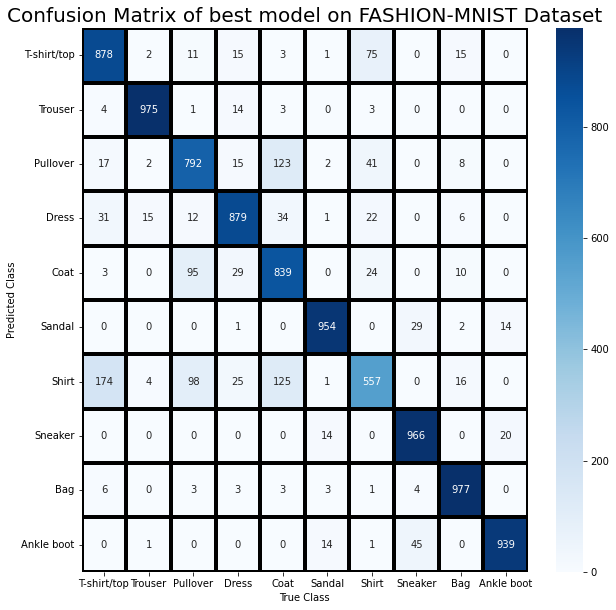

In [ ]:
wandb.init(project="Assignment_1", name="Question_7")

#labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

conf_matrix=metrics.confusion_matrix(np.argmax(y_test,1), np.argmax(y_pred,1))
df_conf_matrix = pd.DataFrame(conf_matrix, index=[i for i in labels], columns=[i for i in labels])

plt.figure(figsize=(10, 10))
ax = sns.heatmap(df_conf_matrix, annot=True,  cmap='Blues', fmt='d',linewidths=3, linecolor='black')
ax.set_yticklabels(labels,rotation=0)
plt.xlabel("True Class")  
plt.ylabel("Predicted Class")
plt.title('Confusion Matrix of best model on FASHION-MNIST Dataset', fontsize=20)

wandb.log({"Confusion_matrix": wandb.Image(plt)})

plt.show()

wandb.finish()

##Question 8: Squared loss v/s Cross entropy loss

Comparison of the best model using Cross Entropy v/s Squared Loss

In [17]:
#Add layer sizes for the hidden layers
layers = [32, 64, 128]

optimizers = {"gradient_descent":GD(), "momentum_gd":MomentumGD(), "nag":NAG(), "rmsprop":RMSProp(), "adam":Adam(), "nadam":Nadam()}
loss_functions = {"cross_entropy":CrossEntropy(), "squared_loss":SquaredErrorLoss()}
activation_functions = {"sigmoid": Sigmoid(), "softmax":Softmax(), "tanh": Tanh(), "relu":ReLU()}

#Select optimizer(adam)
optimizer_adam = optimizers["adam"]
optimizer_parameters_adam = {"learning_rate":0.001, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":0.0005}
optimizer_adam.set_initial_parameters(optimizer_parameters_adam)

#Select loss function
loss_cross_entropy = loss_functions["cross_entropy"]
loss_squared = loss_functions["squared_loss"]

#Select activation(hidden layers)
activation_tanh = activation_functions["tanh"]

#Select activation(output layer)
output_activation_softmax = activation_functions["softmax"]

train_losses_crossentropy = []
train_accuracy_crossentropy = []
val_losses_crossentropy = []
val_accuracy_crossentropy = []

train_losses_squareloss = []
train_accuracy_squareloss = []
val_losses_squareloss = []
val_accuracy_squareloss = []

model_crossEnt = FeedForwardNeuralNetwork(layers, optimizer_adam, loss_cross_entropy, activation_tanh, output_activation_softmax, 15, 128, initialization = "Xavier-Normal", train_losses_list = train_losses_crossentropy, train_accuracy_list = train_accuracy_crossentropy, val_losses_list = val_losses_crossentropy, val_accuracy_list = val_accuracy_crossentropy)
model_squared = FeedForwardNeuralNetwork(layers, optimizer_adam, loss_squared, activation_tanh, output_activation_softmax, 15, 128, initialization = "Xavier-Normal", train_losses_list = train_losses_squareloss, train_accuracy_list = train_accuracy_squareloss, val_losses_list = val_losses_squareloss, val_accuracy_list = val_accuracy_squareloss)

model_crossEnt.fit(x_train, y_train, x_val, y_val)
print("-----------------------------------------------------------------------------------")
model_squared.fit(x_train, y_train, x_val, y_val)



Epoch:  1  Training Loss:  0.5906556086153221  Validation Loss: 0.45769211254103775  Training Accuracy:  0.7897037037037037  Validation Accuracy: 0.8263333333333334
Epoch:  2  Training Loss:  0.4189810735972017  Validation Loss: 0.40195854797093306  Training Accuracy:  0.847925925925926  Validation Accuracy: 0.8476666666666667
Epoch:  3  Training Loss:  0.3808704571518979  Validation Loss: 0.38035096344251657  Training Accuracy:  0.8622037037037037  Validation Accuracy: 0.8601666666666666
Epoch:  4  Training Loss:  0.35698552320487015  Validation Loss: 0.36359364526627524  Training Accuracy:  0.8708703703703704  Validation Accuracy: 0.868
Epoch:  5  Training Loss:  0.33913932867720065  Validation Loss: 0.35180295767897  Training Accuracy:  0.8773703703703704  Validation Accuracy: 0.8711666666666666
Epoch:  6  Training Loss:  0.3247543739892887  Validation Loss: 0.3434713700468033  Training Accuracy:  0.8824444444444445  Validation Accuracy: 0.8746666666666667
Epoch:  7  Training Loss: 

(0.07362589881169948, 0.09179079525154939, 0.9008148148148148, 0.873)

###Logging the results of comparison using plots onto wandb

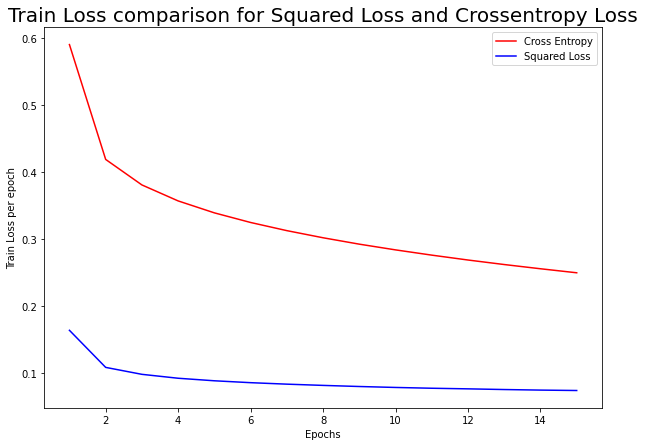

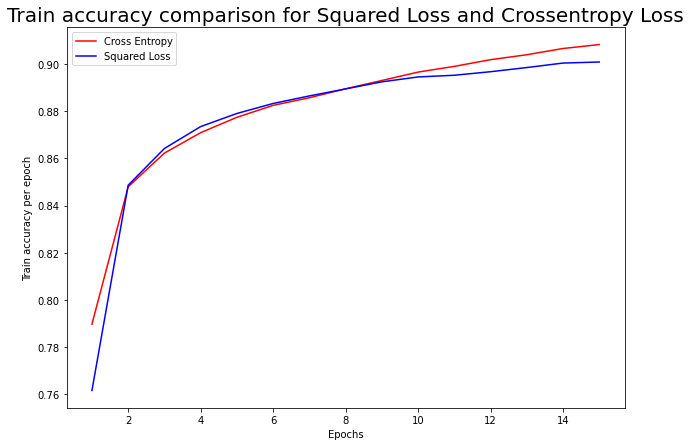

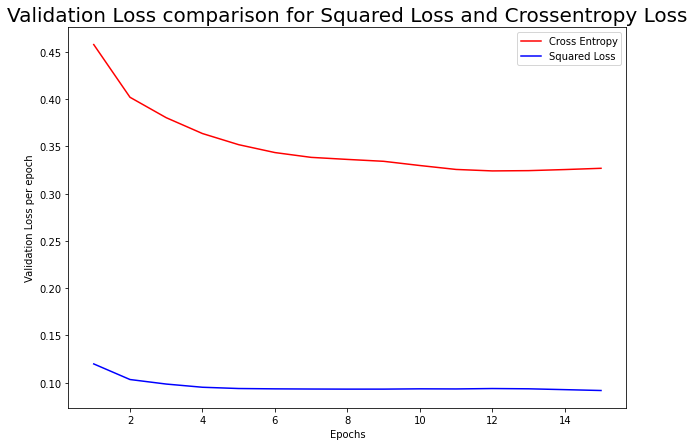

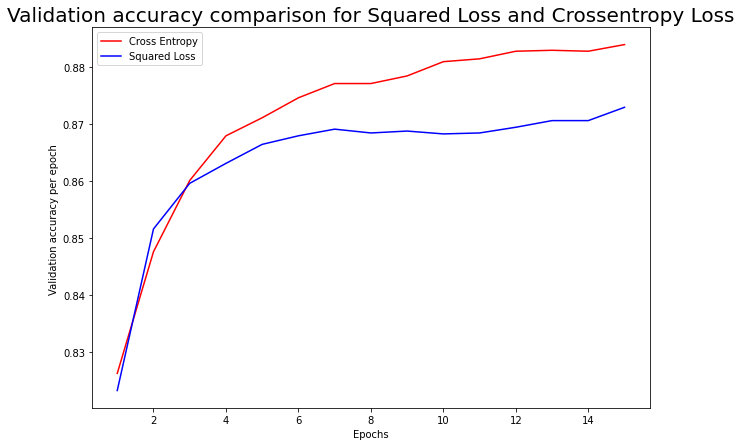

In [ ]:
wandb.init(project="Assignment_1", name="Question_8")

epochs = list(range(1, len(train_losses_squareloss)+1))

plt.figure(figsize=(10, 7))
plt.plot(epochs, train_losses_crossentropy, 'r', label ='Cross Entropy')
plt.plot(epochs, train_losses_squareloss, 'b', label ='Squared Loss') 
plt.legend()
plt.xlabel("Epochs")  
plt.ylabel("Train Loss per epoch")
plt.title('Train Loss comparison for Squared Loss and Crossentropy Loss', fontsize=20)
wandb.log({"Train Loss per epoch for Squared v/s CrossEntropy Loss ": wandb.Image(plt)})
plt.show()



plt.figure(figsize=(10, 7))
plt.plot(epochs, train_accuracy_crossentropy, 'r', label ='Cross Entropy')
plt.plot(epochs, train_accuracy_squareloss, 'b', label ='Squared Loss') 
plt.legend()
plt.xlabel("Epochs")  
plt.ylabel("Train accuracy per epoch")
plt.title('Train accuracy comparison for Squared Loss and Crossentropy Loss', fontsize=20)
wandb.log({"Train accuracy per epoch for Squared v/s CrossEntropy Loss ": wandb.Image(plt)})
plt.show()



plt.figure(figsize=(10, 7))
plt.plot(epochs, val_losses_crossentropy, 'r', label ='Cross Entropy')
plt.plot(epochs, val_losses_squareloss, 'b', label ='Squared Loss') 
plt.legend()
plt.xlabel("Epochs")  
plt.ylabel("Validation Loss per epoch")
plt.title('Validation Loss comparison for Squared Loss and Crossentropy Loss', fontsize=20)
wandb.log({"Validation Loss per epoch for Squared v/s CrossEntropy Loss ": wandb.Image(plt)})
plt.show()



plt.figure(figsize=(10, 7))
plt.plot(epochs, val_accuracy_crossentropy, 'r', label ='Cross Entropy')
plt.plot(epochs, val_accuracy_squareloss, 'b', label ='Squared Loss') 
plt.legend()
plt.xlabel("Epochs")  
plt.ylabel("Validation accuracy per epoch ")
plt.title('Validation accuracy comparison for Squared Loss and Crossentropy Loss', fontsize=20)
wandb.log({"Validation accuracy per epoch for Squared v/s CrossEntropy Loss ": wandb.Image(plt)})
plt.show()



wandb.finish()

##Question 10: MNIST (Number) dataset classification using the top 3 hyperparameter sets from the models of Fashion MNIST

###Download MNIST numbers dataset, normalize and split into train and validation set

In [ ]:
(x_train_mnist_full, y_train_mnist_full), (x_test_mnist, y_test_mnist) = mnist.load_data()

#Normalize the data
x_train_mnist_full = x_train_mnist_full/255.0
x_test_mnist = x_test_mnist/255.0

#Splitting to get 10% data as validation set
x_train_mnist, x_val_mnist, y_train_mnist, y_val_mnist = train_test_split(x_train_mnist_full, y_train_mnist_full, test_size=0.1, random_state=137)

y_train_mnist_unencoded = y_train_mnist
#One hot encoding of the class labels
encoder = OneHotEncoder()
y_train_mnist = encoder.fit_transform(np.expand_dims(y_train_mnist,1)).toarray()
y_val_mnist = encoder.fit_transform(np.expand_dims(y_val_mnist,1)).toarray()
y_test_mnist = encoder.fit_transform(np.expand_dims(y_test_mnist,1)).toarray()


11501568/11490434 [==============================] - 0s 0us/step


### Create the 3 models as follows:

1. MODEL 1: Epoch:15, activation:tanh, optimizer:adam, layers : [32,64,128], weight_decay:0.0005, gamma:0.6, learning_rate:0.001, batch_size:128
2. MODEL 2: Epoch:15, activation:tanh, optimizer:sgd, layers : [32,64,128, 256], weight_decay:0, gamma:0.6, learning_rate:0.001, batch_size:32
3. MODEL 3: Epoch:12, activation:tanh, optimizer:rmsprop, layers : [32,64,128], weight_decay:0, gamma:0.6, learning_rate:0.001, batch_size:32

In [ ]:
#Add layer sizes for the hidden layers
layers_3 = [32, 64, 128]
layers_4 = [32, 64, 128, 256]

optimizers = {"gradient_descent":GD(), "momentum_gd":MomentumGD(), "nag":NAG(), "rmsprop":RMSProp(), "adam":Adam(), "nadam":Nadam()}
loss_functions = {"cross_entropy":CrossEntropy(), "squared_loss":SquaredErrorLoss()}
activation_functions = {"sigmoid": Sigmoid(), "softmax":Softmax(), "tanh": Tanh(), "relu":ReLU()}

#Select optimizer(sgd)
optimizer_sgd = optimizers["gradient_descent"]
optimizer_parameters_sgd = {"learning_rate":0.001, "weight_decay":0.0}
optimizer_sgd.set_initial_parameters(optimizer_parameters_sgd)

#Select optimizer(adam)
optimizer_adam = optimizers["adam"]
optimizer_parameters_adam = {"learning_rate":0.001, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":0.0005}
optimizer_adam.set_initial_parameters(optimizer_parameters_adam)

#Select optimizer(rmsprop)
optimizer_rmsprop = optimizers["rmsprop"]
optimizer_parameters_rmsprop = {"learning_rate":0.001, "gamma":0.6, "epsilon":1e-8, "weight_decay":0.0}
optimizer_rmsprop.set_initial_parameters(optimizer_parameters_rmsprop)


#Select loss function
loss_cross_entropy = loss_functions["cross_entropy"]
loss_squared = loss_functions["squared_loss"]

#Select activation(hidden layers)
activation_tanh = activation_functions["tanh"]

#Select activation(output layer)
output_activation_softmax = activation_functions["softmax"]


### Fitting the 3 best model hyperparameters with the train data and checking validation accuracy

In [ ]:
model_mnist_1 = FeedForwardNeuralNetwork(layers_3, optimizer_adam, CrossEntropy(), Tanh(), Softmax(), 15, 128, initialization = "Xavier-Normal")
model_mnist_1.fit(x_train_mnist, y_train_mnist, x_val_mnist, y_val_mnist)

Epoch:  1  Training Loss:  0.41073149293086636  Validation Loss: 0.22866350520259324  Training Accuracy:  0.8837592592592592  Validation Accuracy: 0.9336666666666666
Epoch:  2  Training Loss:  0.19884359980416677  Validation Loss: 0.16872381204267525  Training Accuracy:  0.940962962962963  Validation Accuracy: 0.9505
Epoch:  3  Training Loss:  0.14965588726762935  Validation Loss: 0.14585005882389732  Training Accuracy:  0.9555185185185185  Validation Accuracy: 0.9566666666666667
Epoch:  4  Training Loss:  0.12188738030480784  Validation Loss: 0.13561777810388953  Training Accuracy:  0.9635  Validation Accuracy: 0.9605
Epoch:  5  Training Loss:  0.102772847344875  Validation Loss: 0.13076245401588585  Training Accuracy:  0.9685925925925926  Validation Accuracy: 0.9618333333333333
Epoch:  6  Training Loss:  0.08830473422403737  Validation Loss: 0.12795487475558295  Training Accuracy:  0.9729814814814814  Validation Accuracy: 0.961
Epoch:  7  Training Loss:  0.07667572477647194  Validati

(0.02698002946049933,
 0.1541914689129405,
 0.9931666666666666,
 0.9633333333333334)

In [ ]:
model_mnist_2 = FeedForwardNeuralNetwork(layers_4, optimizer_sgd, CrossEntropy(), Tanh(), Softmax(), 10, 32, initialization = "Xavier-Normal")
model_mnist_2.fit(x_train_mnist, y_train_mnist, x_val_mnist, y_val_mnist)

Epoch:  1  Training Loss:  0.4047825036687557  Validation Loss: 0.2363341750042909  Training Accuracy:  0.8832962962962962  Validation Accuracy: 0.9295
Epoch:  2  Training Loss:  0.21450932676794235  Validation Loss: 0.17821919820261045  Training Accuracy:  0.9366111111111111  Validation Accuracy: 0.951
Epoch:  3  Training Loss:  0.16396836343485885  Validation Loss: 0.15192198489784853  Training Accuracy:  0.9513148148148148  Validation Accuracy: 0.9585
Epoch:  4  Training Loss:  0.13405215978408602  Validation Loss: 0.1384978450315099  Training Accuracy:  0.9598518518518518  Validation Accuracy: 0.9626666666666667
Epoch:  5  Training Loss:  0.11419506317920394  Validation Loss: 0.13113202845418856  Training Accuracy:  0.9658888888888889  Validation Accuracy: 0.9653333333333334
Epoch:  6  Training Loss:  0.09991556756453553  Validation Loss: 0.12683556940803298  Training Accuracy:  0.9702777777777778  Validation Accuracy: 0.9661666666666666
Epoch:  7  Training Loss:  0.088999068668429

(0.06570523724393633, 0.12096225777313425, 0.981, 0.9691666666666666)

In [ ]:
model_mnist_3 = FeedForwardNeuralNetwork(layers_3, optimizer_rmsprop, CrossEntropy(), Tanh(), Softmax(), 12, 32, initialization = "Xavier-Normal")
model_mnist_3.fit(x_train_mnist, y_train_mnist, x_val_mnist, y_val_mnist)


Epoch:  1  Training Loss:  0.33381318310126923  Validation Loss: 0.20253641383475854  Training Accuracy:  0.9003888888888889  Validation Accuracy: 0.9398333333333333
Epoch:  2  Training Loss:  0.1881230107996442  Validation Loss: 0.1598765639715446  Training Accuracy:  0.9439814814814815  Validation Accuracy: 0.9545
Epoch:  3  Training Loss:  0.1505517654384135  Validation Loss: 0.14564386897833984  Training Accuracy:  0.9551111111111111  Validation Accuracy: 0.9583333333333334
Epoch:  4  Training Loss:  0.1306969940512828  Validation Loss: 0.14045186956679195  Training Accuracy:  0.9618703703703704  Validation Accuracy: 0.9626666666666667
Epoch:  5  Training Loss:  0.11803450924758235  Validation Loss: 0.1371803743622551  Training Accuracy:  0.965925925925926  Validation Accuracy: 0.9621666666666666
Epoch:  6  Training Loss:  0.10921470393228362  Validation Loss: 0.13582253563987062  Training Accuracy:  0.9683703703703703  Validation Accuracy: 0.9635
Epoch:  7  Training Loss:  0.10234

(0.07937863683932539,
 0.13602860555992427,
 0.9777037037037037,
 0.9661666666666666)

### Predicting accuracy for Test data

In [ ]:
y_pred_mnist_1 = model_mnist_1.predict(x_test_mnist)
print("Test Accuracy for model 1:", accuracy(np.argmax(y_test_mnist,1), np.argmax(y_pred_mnist_1,1)))

y_pred_mnist_2 = model_mnist_2.predict(x_test_mnist)
print("Test Accuracy for model 2:", accuracy(np.argmax(y_test_mnist,1), np.argmax(y_pred_mnist_2,1)))

y_pred_mnist_3 = model_mnist_3.predict(x_test_mnist)
print("Test Accuracy for model 3:", accuracy(np.argmax(y_test_mnist,1), np.argmax(y_pred_mnist_3,1)))


Test Accuracy for model 1: 0.9666
Test Accuracy for model 2: 0.9671
Test Accuracy for model 3: 0.9643
